## 0. Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn import preprocessing
from utils import *
from tqdm.notebook import tqdm
from usad import *

In [2]:
!nvidia-smi -L

#device = get_default_device()
#torch.cuda.is_available()

device = torch.device('cpu')

#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)

# Transform all columns into float64
for i in list(normal):
    normal[i] = normal[i].apply(lambda x: str(x).replace(",", "."))
normal = normal.astype(float)


min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)


# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)


x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)


window_size = 12

windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]


GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-2e29bca1-5e43-6381-de60-b035ad365ec9)


C:\Users\sngmn\AppData\Local\Temp\ipykernel_8284\3667843882.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")
C:\Users\sngmn\AppData\Local\Temp\ipykernel_8284\3667843882.py:25: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")


In [5]:
'''test -> attack / normal'''

attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv", sep=";")
labels = [int(label != 'Normal') for label in attack["Normal/Attack"].values]

# Create a DataFrame with "attack" data and "labels"
attack_data = attack.copy()
normal_data = attack_data[attack_data["Normal/Attack"] == "Normal"]
attack_data = attack_data[attack_data["Normal/Attack"] == "Attack"]

# Drop the columns
attack_only = attack_data.drop(["Timestamp" ,"Normal/Attack"], axis=1)
normal_only = normal_data.drop(["Timestamp" ,"Normal/Attack"], axis=1)

# Transform all columns into float64
for i in list(attack_only):
    attack_only[i]=attack_only[i].apply(lambda x: str(x).replace("," , "."))
attack_only = attack_only.astype(float)

# Transform all columns into float64
for i in list(normal_only):
    normal_only[i]=normal_only[i].apply(lambda x: str(x).replace("," , "."))
normal_only = normal_only.astype(float)


C:\Users\sngmn\AppData\Local\Temp\ipykernel_27276\4176763927.py:3: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv", sep=";")
C:\Users\sngmn\AppData\Local\Temp\ipykernel_27276\4176763927.py:3: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv", sep=";")
C:\Users\sngmn\AppData\Local\Temp\ipykernel_27276\4176763927.py:3: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv", sep=";")


## 1. Training usad with varying decimation levels.

In [ ]:
import torch.utils.data as data_utils
import importlib
import usad
importlib.reload(usad)
from usad import *



BATCH_SIZE =  7919
N_EPOCHS = 70
hidden_size = 40

w_size= 12 * 51  #window size * feature size
z_size= 12 * hidden_size  # window size * hidden size


window_size = 12
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]



test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

max_decimation = 3 ## <- 몇까지 decimation할것인지
for i in tqdm(range(1, max_decimation + 1)):
    if i == 1:
        torch.save(model.state_dict(),'model_untrained_42.pth') # "42" means random seed number

    ## AVERAGE POOLING
    normal_ = normal.rolling(i).mean().dropna()[::i]

    ## WINDOW NORMAL
    windows_normal = normal_.values[np.arange(window_size)[None, :] + np.arange(normal_.shape[0]-window_size)[:, None]]
    windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]

    train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
    ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    ## VALIDATION
    windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]
    val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
    ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model.load_state_dict(torch.load('model_untrained_42.pth'))

    training(N_EPOCHS,model,train_loader,val_loader,num=i)



## 2. Training usadAE ( finetuning model ) with varying decimation levels

In [26]:
import importlib
import usadAE
importlib.reload(usadAE)
from usadAE import *

for i in range(1,max_decimation + 1):
    finetune_with_deci(normal,hidden_size, decimation = i, latent_size = 1, epochs_per_tune = 20, window_size = 12, BATCH_SIZE = 7919,
                             opt_func = torch.optim.Adam)


Pretrained weights loaded successfully.
Epoch [0], val_loss1: 0.0304, val_loss2: 0.0304
Model saved after decimation 1
Pretrained weights loaded successfully.
Epoch [0], val_loss1: 0.0325, val_loss2: 0.0323
Model saved after decimation 2


FileNotFoundError: [Errno 2] No such file or directory: 'model_3_deci.pth'

In [28]:
import importlib
import usadAE
importlib.reload(usadAE)
from usadAE import *


start_deci = 1
max_decimation = 1

for i in tqdm(range(start_deci,max_decimation + 1)):
    encode_data(normal, decimation = 1, latent_size = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

## 3. Performance

### 3.1.1 usad : F1 & AUC

In [7]:
import importlib
import usad
importlib.reload(usad)
from usad import *

init_decimation = 1
max_decimation = 3

for i in tqdm(range(init_decimation,max_decimation)):
    bestf1_values = []
    precision_values = []
    recall_values = []
    thres_values = []


    model = UsadModel(w_size,z_size)

    model_path = f'model_{i}_deci.pth'
    model.load_state_dict(torch.load(model_path))

    results=testing(model,test_loader)

    y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                         results[-1].detach().cpu().numpy()])
    auc = AUC(y_test,y_pred)

    bestf1, precision, recall, thres = calculate_max_score(y_test, y_pred, num_thresholds=200)
    print(bestf1, precision, recall, thres)

    # Append the values to the corresponding lists
    bestf1_values.append(bestf1)
    precision_values.append(precision)
    recall_values.append(recall)
    thres_values.append(thres)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'bestf1': bestf1_values,
    'precision': precision_values,
    'recall': recall_values,
    'threshold': thres_values
})

# Save the DataFrame to a csv file
df.to_csv(f'F1_usad_from{init_decimation}_to{max_decimation}_deci.csv', index=False)


  0%|          | 0/2 [00:00<?, ?it/s]

0.715610305318233 0.9108407328312914 0.5892993491619096 0.507537688442211



KeyboardInterrupt



### 3.1.2 usadAE : F1 & AUC

In [9]:
import importlib
import usadAE
importlib.reload(usadAE)
from usadAE import *

latent_size = 1
init_decimation = 1
max_decimation = 3

for i in tqdm(range(init_decimation,max_decimation)):
    bestf1_values = []
    precision_values = []
    recall_values = []
    thres_values = []
    auc_values = []


    model = UsadAE(w_size,z_size, latent_size = latent_size)

    model_path = f'tuned_{i}_deci.pth'
    model.load_state_dict(torch.load(model_path))


    results=testing(model,test_loader)

    y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                         results[-1].detach().cpu().numpy()])


    bestf1, precision, recall, thres = calculate_max_score(y_test, y_pred, num_thresholds = 200)
    auc = AUC(y_test,y_pred)
    print(bestf1, precision, recall, thres, auc)


    # Append the values to the corresponding lists
    bestf1_values.append(bestf1)
    precision_values.append(precision)
    recall_values.append(recall)
    thres_values.append(thres)
    auc_values.append(auc)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'bestf1': bestf1_values,
    'precision': precision_values,
    'recall': recall_values,
    'threshold': thres_values,
    'AUC' : auc
})

# Save the DataFrame to a csv file
df.to_csv(f'F1_usadAE_from{init_decimation}_to{max_decimation}_deci.csv', index=False)


  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



### 3.2 Average of anomaly score

### 3.2.1 usad : average of anomaly score about test-attack only

In [46]:
import importlib
import usad
importlib.reload(usad)
from usad import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

'''지금은 윈도우 하나씩 넣는데 -> Batch 단위로 처리하도록 바꾸면 좋을듯'''

window_size = 12
feature_size = 51


# Dimension Setting
hidden_size = 40

w_size = window_size * feature_size
z_size = window_size * hidden_size

# MODEL
model = UsadModel(w_size,z_size)


for i in range(1,max_decimation+1):
    decimation = i
    model_path = f'model_{decimation}_deci.pth'
    model.load_state_dict(torch.load(model_path))

    # Save normal_train to CSV
    #normal_train.to_csv("normal_train.csv", index=False)

    # Create an empty list to store w
    w_list = []

    # Iterate over normal_train
    with torch.no_grad():
        for i in tqdm(range(0, len(attack_only)-window_size)):
            split_normal = torch.tensor(attack_only[i:i + window_size].values, dtype=torch.float).flatten()
            w = model.forward_score(split_normal)
            # Reshape w to 2D array: (time_step, feature_size)
            w = w.unsqueeze(0)
            w_list.append(w)




    # Concatenate all w arrays along time-step axis
    w_array = np.concatenate(w_list, axis=0)

    # Create a DataFrame for w
    w_df = pd.DataFrame(w_array)
    print(w_df.mean())

    # Save w to CSV
    w_df.to_csv(f"model_score_{decimation}_test_attack.csv", index=False)


  0%|          | 0/54572 [00:00<?, ?it/s]

0    43623.03125
dtype: float32


  0%|          | 0/54572 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 3.2.2 usad : average of anomaly score about test-normal only

In [47]:
import importlib
import usad
importlib.reload(usad)
from usad import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

'''지금은 윈도우 하나씩 넣는데 -> Batch 단위로 처리하도록 바꾸면 좋을듯'''

window_size = 12
feature_size = 51


# Dimension Setting
hidden_size = 40

w_size = window_size * feature_size
z_size = window_size * hidden_size

# MODEL
model = UsadModel(w_size,z_size)


for i in range(1,max_decimation+1):
    decimation = i
    model_path = f'model_{decimation}_deci.pth'
    model.load_state_dict(torch.load(model_path))

    # Save normal_train to CSV
    #normal_train.to_csv("normal_train.csv", index=False)

    # Create an empty list to store w
    w_list = []

    # Iterate over normal_train
    with torch.no_grad():
        for i in tqdm(range(0, len(normal_only)-window_size)):
            split_normal = torch.tensor(normal_only[i:i + window_size].values, dtype=torch.float).flatten()
            w = model.forward_score(split_normal)
            # Reshape w to 2D array: (time_step, feature_size)
            w = w.unsqueeze(0)
            w_list.append(w)




    # Concatenate all w arrays along time-step axis
    w_array = np.concatenate(w_list, axis=0)

    # Create a DataFrame for w
    w_df = pd.DataFrame(w_array)
    print(w_df.mean())

    # Save w to CSV
    w_df.to_csv(f"model_score_{decimation}_test_normal.csv", index=False)


  0%|          | 0/395286 [00:00<?, ?it/s]

0    45842.085938
dtype: float32


  0%|          | 0/395286 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 3.2.2 usadAE : average of anomaly score about test-attack only

In [ ]:
import importlib
import usad
importlib.reload(usad)
from usad import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

'''지금은 윈도우 하나씩 넣는데 -> Batch 단위로 처리하도록 바꾸면 좋을듯'''

window_size = 12
feature_size = 51


# Dimension Setting
hidden_size = 40

w_size = window_size * feature_size
z_size = window_size * hidden_size

# MODEL
model = UsadAE(w_size,z_size,latent_size=1)


for i in range(1,max_decimation+1):
    decimation = i
    model_path = f'tuned_{decimation}_deci.pth'
    model.load_state_dict(torch.load(model_path))

    # Save normal_train to CSV
    #normal_train.to_csv("normal_train.csv", index=False)

    # Create an empty list to store w
    w_list = []

    # Iterate over normal_train
    with torch.no_grad():
        for i in tqdm(range(0, len(attack_only)-12)):
            split_normal = torch.tensor(attack_only[i:i+12].values, dtype=torch.float).flatten()
            w = model.forward_score(split_normal)
            # Reshape w to 2D array: (time_step, feature_size)
            w = w.unsqueeze(0)
            w_list.append(w)




    # Concatenate all w arrays along time-step axis
    w_array = np.concatenate(w_list, axis=0)

    # Create a DataFrame for w
    w_df = pd.DataFrame(w_array)
    print(w_df.mean())

    # Save w to CSV
    w_df.to_csv(f"tuned_score_{decimation}_test_attack.csv", index=False)


### 3.2.2 usadAE : average of anomaly score about test-normal only

In [45]:
import importlib
import usad
importlib.reload(usad)
from usad import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

'''지금은 윈도우 하나씩 넣는데 -> Batch 단위로 처리하도록 바꾸면 좋을듯'''

window_size = 12
feature_size = 51


# Dimension Setting
hidden_size = 40

w_size = window_size * feature_size
z_size = window_size * hidden_size

# MODEL
model = UsadAE(w_size,z_size,latent_size=1)


for i in range(1,max_decimation+1):
    decimation = i
    model_path = f'tuned_{decimation}_deci.pth'
    model.load_state_dict(torch.load(model_path))

    # Save normal_train to CSV
    #normal_train.to_csv("normal_train.csv", index=False)

    # Create an empty list to store w
    w_list = []

    # Iterate over normal_train
    with torch.no_grad():
        for i in tqdm(range(0, len(normal_only)-12)):
            split_normal = torch.tensor(normal_only[i:i+12].values, dtype=torch.float).flatten()
            w = model.forward_score(split_normal)
            # Reshape w to 2D array: (time_step, feature_size)
            w = w.unsqueeze(0)
            w_list.append(w)




    # Concatenate all w arrays along time-step axis
    w_array = np.concatenate(w_list, axis=0)

    # Create a DataFrame for w
    w_df = pd.DataFrame(w_array)
    print(w_df.mean())

    # Save w to CSV
    w_df.to_csv(f"tuned_score_{decimation}_test_normal.csv", index=False)


  0%|          | 0/395286 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 3.3 Total variance distance (TVD)

### 3.3.1 usad : TVD

In [58]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad


def tvd_ft(x):
    x_reshaped = np.array([x]).reshape(-1, 1)
    return 0.5 * abs(np.exp(kde1.score_samples(x_reshaped)) - np.exp(kde2.score_samples(x_reshaped)))


init_decimation = 1
max_decimation = 1
tvd_values = []
for i in tqdm(range(init_decimation,max_decimation+1)):
    decimation = i

    data1 = pd.read_csv(f"model_score_{decimation}_test_attack.csv")
    data2 = pd.read_csv(f"model_score_{decimation}_test_normal.csv")

    # KDE
    B1 = 1.06 * np.std(data1['0']) * len(data1['0']) ** (-1/5)
    B2 = 1.06 * np.std(data2['0']) * len(data2['0']) ** (-1/5)


    kde1 = KernelDensity(bandwidth = B1).fit(data1['0'].values.reshape(-1, 1))
    kde2 = KernelDensity(bandwidth = B2).fit(data2['0'].values.reshape(-1, 1))


    # Find the min and max across both datasets
    min_val = min(data1['0'].min(), data2['0'].min())
    max_val = max(data1['0'].max(), data2['0'].max())

    # Numerical integration to calculate the TVD
    tvd, error = quad(tvd_ft, min_val, max_val)

    tvd_values.append(tvd)
    print(tvd)

# Save TVD values as a CSV file
tvd_df = pd.DataFrame({"TVD": tvd_values})
tvd_df.to_csv(f"model_tvd_from{init_decimation}_to{max_decimation}.csv", index=False)



  0%|          | 0/1 [00:00<?, ?it/s]

0.4942924832583169
[0.4942924832583169]


C:\Users\sngmn\AppData\Local\Temp\ipykernel_10772\3717325830.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tvd, error = quad(tvd_ft, min_val, max_val)


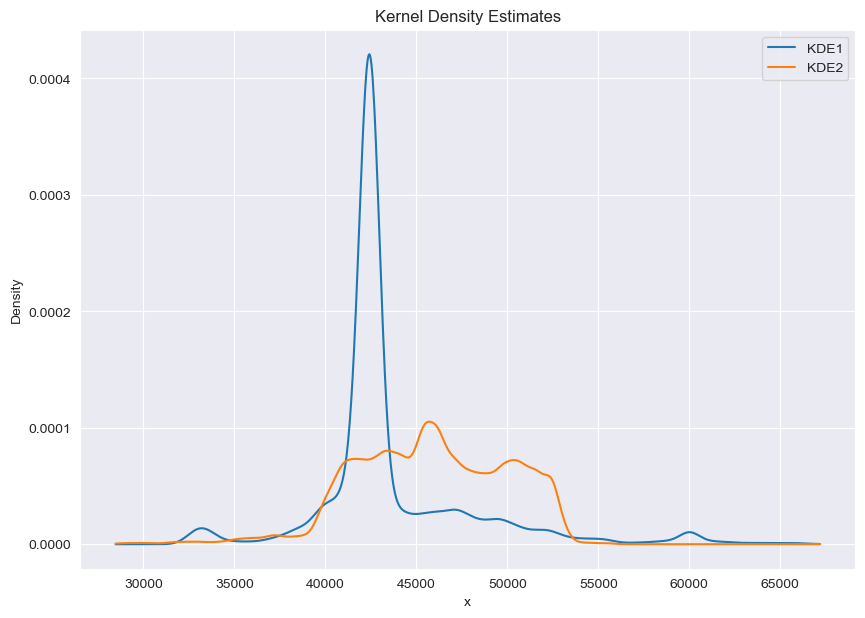

In [60]:
import matplotlib.pyplot as plt

# Calculate densities
densities1 = np.exp(kde1.score_samples(x))
densities2 = np.exp(kde2.score_samples(x))

# Create the plots
plt.figure(figsize=(10,7))
plt.plot(x, densities1, label='KDE1')
plt.plot(x, densities2, label='KDE2')
plt.legend()
plt.title('Kernel Density Estimates')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

### 3.3.1 usadAE : TVD

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad


def tvd_ft(x):
    x_reshaped = np.array([x]).reshape(-1, 1)
    return 0.5 * abs(np.exp(kde1.score_samples(x_reshaped)) - np.exp(kde2.score_samples(x_reshaped)))


init_decimation = 1
max_decimation = 1
tvd_values = []
for i in tqdm(range(init_decimation,max_decimation+1)):
    decimation = i

    data1 = pd.read_csv(f"tuned_score_{decimation}_test_attack.csv")
    data2 = pd.read_csv(f"tuned_score_{decimation}_test_normal.csv")

    # KDE
    B1 = 1.06 * np.std(data1['0']) * len(data1['0']) ** (-1/5)
    B2 = 1.06 * np.std(data2['0']) * len(data2['0']) ** (-1/5)


    kde1 = KernelDensity(bandwidth = B1).fit(data1['0'].values.reshape(-1, 1))
    kde2 = KernelDensity(bandwidth = B2).fit(data2['0'].values.reshape(-1, 1))


    # Find the min and max across both datasets
    min_val = min(data1['0'].min(), data2['0'].min())
    max_val = max(data1['0'].max(), data2['0'].max())


    # Numerical integration to calculate the TVD
    tvd, error = quad(tvd_ft, min_val, max_val)

    tvd_values.append(tvd)
    print(tvd)

# Save TVD values as a CSV file
tvd_df = pd.DataFrame({"TVD": tvd_values})
tvd_df.to_csv(f"model_tvd_from{init_decimation}_to{max_decimation}.csv", index=False)


## 4. Entropy(shannon, spectral, bubble, phase) measure per decimation(AVERAGE POOLING)

  0%|          | 0/51 [00:00<?, ?it/s]

D:\TimeComplexity\Entropy.py:157: RuntimeWarning: divide by zero encountered in log2
  se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()  # Spectral entropy
D:\TimeComplexity\Entropy.py:157: RuntimeWarning: invalid value encountered in multiply
  se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()  # Spectral entropy
D:\TimeComplexity\Entropy.py:156: RuntimeWarning: invalid value encountered in divide
  psd_norm = np.divide(psd, psd.sum())  # Normalize to unit area


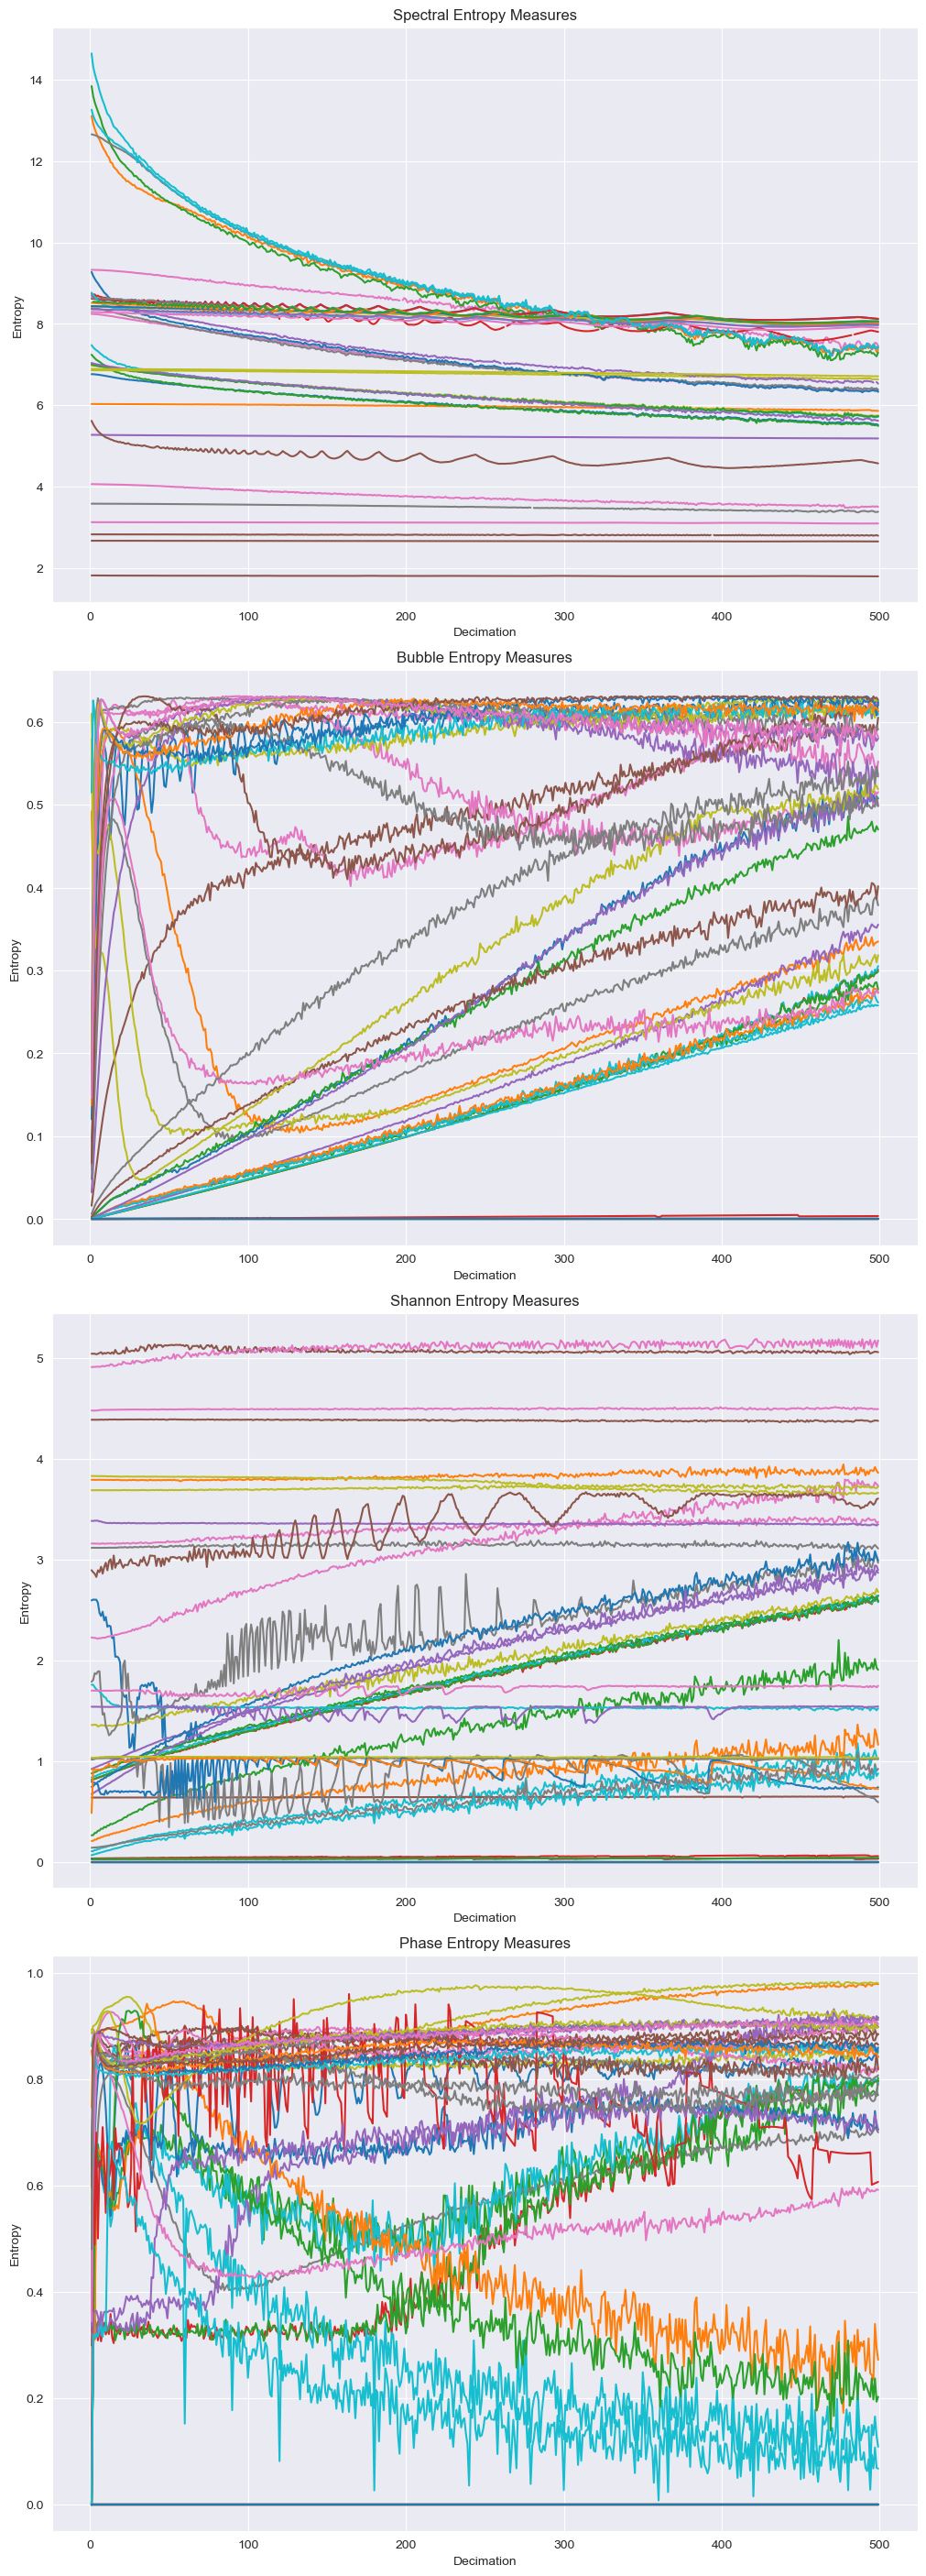

In [11]:
from Entropy import *

'''AVERAGE POOLING 썼음 <- 1. 건너뛰는 Decimation 보다 안정적으로 나옴 '''
'''Shannon : basic entropy , Others : robust to time lengths '''
'''Raw Sensor에 대해서 계산한 것 -> latent feature에 대해서 계산해야 함'''
'''entropy base는 모두 nats로 통일됨'''

decimation_values = range(1,500)  # decimation 값 설정

# entropy parameters
spectral_sf = 1 # psd에서 x축 자체는 달라질 수 있어도 결국 분포를 통해 엔트로피를 계산하는 거니까 몇으로하든 상관없을 듯
spectral_method = 'fft' # welch 쓰려면 파라미터 조정이 필요함 -> fft
spectral_normalize = False # True로 하는 건 잘못된 거 같음
phase_K = 8   # angle seperation number : 기본인 4로 했을 때 보다 8일 때 안정적으로 나옴
bubble_embedding_dim = 3
shannon_bins = 50


# 각 엔트로피 측정값에 대해 별도의 리스트 생성
spectral_values = np.zeros((len(normal.columns), len(decimation_values)))
bubble_values = np.zeros((len(normal.columns), len(decimation_values)))
shannon_values = np.zeros((len(normal.columns), len(decimation_values)))
phase_values = np.zeros((len(normal.columns), len(decimation_values)))

# DataFrame의 각 열에 대해
for idx, column in enumerate(tqdm(normal.columns)):
    # decimation 값별로
    for decimation_idx, decimation in enumerate(decimation_values):
        # 데이터 그룹 만들기
        x_values = np.array(normal[column].rolling(decimation).mean()[::decimation].dropna().values)

        # 각 엔트로피 측정값 계산
        spec = spectral_entropy(x_values,sf = spectral_sf, method= spectral_method, normalize= spectral_normalize)
        bubble = BubbEn(x_values, m = bubble_embedding_dim)[0][0]
        shannon = ShannonEn(x_values, num_bins = shannon_bins)
        phase = PhasEn(x_values, )

        # 각 엔트로피 측정값을 리스트에 추가
        spectral_values[idx, decimation_idx] = spec
        bubble_values[idx, decimation_idx] = bubble
        shannon_values[idx, decimation_idx] = shannon
        phase_values[idx, decimation_idx] = phase

# 그래프 그리기
fig, axs = plt.subplots(4, figsize=(10, 7 * 4), constrained_layout=True)

entropy_values = [spectral_values, bubble_values, shannon_values, phase_values]
entropy_names = ['Spectral', 'Bubble', 'Shannon', 'Phase']

for i, (ax, entropy_value, entropy_name) in enumerate(zip(axs, entropy_values, entropy_names)):
    for feature_idx in range(entropy_value.shape[0]):
        ax.plot(decimation_values, entropy_value[feature_idx], label=f'Feature {feature_idx}')
    ax.set_xlabel('Decimation')
    ax.set_ylabel('Entropy')
    ax.set_title(f'{entropy_name} Entropy Measures')
    if entropy_value.shape[0] <= 10:  # Too many legends can clutter the plot
        ax.legend()

plt.show()


In [ ]:
'''Latent feature에 대해서 계산과 시각화 해야함'''

## 5. 상관관계 분석 - 추가예정

### 5.1 PCA

### 5.2 GA2M